In [1]:
import os
from glob import glob

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.utils.data as data
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

import numpy as np
from PIL import Image

# Hyperparameter

In [2]:
print('Num_GPU :', torch.cuda.device_count())

no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
Tensor = torch.cuda.FloatTensor if use_cuda else torch.Tensor

params = {
    'batch_size':70 * torch.cuda.device_count(),
    'test_batch_size':70 * torch.cuda.device_count(),
    'input_size':128,
    'resize_scale':134,
    'crop_size':128,
    'fliplr':True,
    #model params
    'ngf':64,
    'ndf':64,
    'epoch_count':1,
    'epochs':80,
    'log_interval':2,
    'lr':0.0002,    #learning rate for generator
    'beta':3,
    'lamb1':100,
    'lamb2':1,
    'lamb3':0,
    'alpha':3,
    'beta1':0.5,
    'sim_dataroot':'C:/Users/IVCL/Desktop/duck/blender_mix',
    'real_dataroot':'C:/Users/IVCL/Desktop/duck/real',
}

Num_GPU : 2


# Utils

In [3]:
def to_np(x):
    return x.data.cpu().numpy()
        
def plot_train_result(test_image, epoch, save=False,  show=True, fig_size=(8, 8)):
    plt.figure(figsize=fig_size)
    imgs = [to_np(test_image[0]), to_np(test_image[1]), to_np(test_image[2])]
    title = ['Image', 'Rec', 'Predicted Rec']
        
    for i in range(0,3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        img = imgs[i]
        img = img.squeeze()
        img = (((img - img.min()) * 255) / (img.max() - img.min())).transpose(1, 2, 0).astype(np.uint8)
        plt.imshow(img)
        plt.axis('off')

    # save figure
    if save:
        save_fn = './img_per_epoch/epoch_{:d}'.format(epoch+1) + '.png'
        fig.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

# Model

In [4]:
class generator(nn.Module):
    def __init__(self, d=64):
        super(generator,self).__init__()
        #f1
        self.conv1 = nn.Conv2d(3, d, 5, 2, 2)
        self.bn1 = nn.BatchNorm2d(d)
        self.relu1 = nn.LeakyReLU(inplace=True)

        self.conv2 = nn.Conv2d(3, d, 5, 2, 2)
        self.bn2 = nn.BatchNorm2d(d)
        self.relu2 = nn.LeakyReLU(inplace=True)
       
        #f2
        self.conv3 = nn.Conv2d(d*2, d*2, 5, 2, 2)
        self.bn3 = nn.BatchNorm2d(d*2)
        self.relu3 = nn.LeakyReLU(inplace=True)

        self.conv4 = nn.Conv2d(d*2, d*2, 5, 2, 2)
        self.bn4 = nn.BatchNorm2d(d*2)
        self.relu4 = nn.LeakyReLU(inplace=True)
       
        #f3
        self.conv5 = nn.Conv2d(d*4, d*2, 5, 2, 2)
        self.bn5 = nn.BatchNorm2d(d*2)
        self.relu5 = nn.LeakyReLU(inplace=True)

        self.conv6 = nn.Conv2d(d*4, d*2, 5, 2, 2)
        self.bn6 = nn.BatchNorm2d(d*2)
        self.relu6 = nn.LeakyReLU(inplace=True)
       
        #f4
        self.conv7 = nn.Conv2d(d*4, d*4, 5, 2, 2)
        self.bn7 = nn.BatchNorm2d(d*4)
        self.relu7 = nn.LeakyReLU(inplace=True)

        self.conv8 = nn.Conv2d(d*4, d*4, 5, 2, 2)
        self.bn8 = nn.BatchNorm2d(d*4)
        self.relu8 = nn.LeakyReLU(inplace=True)
       
        #encode
        self.fc1 = nn.Linear(int(params['input_size']/16)*int(params['input_size']/16)*d*8, d*4)
        self.fc2 = nn.Linear(d*4,int(params['input_size']/16)*int(params['input_size']/16)*d*4)
        
        #d1
        self.conv9 = nn.ConvTranspose2d(d*4, d*2, 5, 2, 2, 1)
        self.bn9 = nn.BatchNorm2d(d*2)
        self.relu9 = nn.LeakyReLU(inplace=True)
        
        #d1_uni
        self.conv10 = nn.ConvTranspose2d(d*4, d*4, 5, 1, 2)
        self.bn10 = nn.BatchNorm2d(d*4)
        self.relu10 = nn.LeakyReLU(inplace=True)
        
        #d2
        self.conv11 = nn.ConvTranspose2d(d*4, d*2, 5, 2, 2, 1)
        self.bn11 = nn.BatchNorm2d(d*2)
        self.relu11 = nn.LeakyReLU(inplace=True)       

        #d2_uni
        self.conv12 = nn.Conv2d(d*4, d*4, 5, 1, 2)
        self.bn12 = nn.BatchNorm2d(d*4)
        self.relu12 = nn.LeakyReLU(inplace=True)  

        #d3
        self.conv13 = nn.ConvTranspose2d(d*4, d, 5, 2, 2, 1)
        self.bn13 = nn.BatchNorm2d(d)
        self.relu13 = nn.LeakyReLU(inplace=True)          

        #d3_uni
        self.conv14 = nn.Conv2d(d*2, d*2, 5, 1, 2)
        self.bn14 = nn.BatchNorm2d(d*2)
        self.relu14 = nn.LeakyReLU(inplace=True) 
        
        #decode
        self.conv15 = nn.ConvTranspose2d(d*2, 3, 5, 2, 2, 1)
        self.conv16 = nn.ConvTranspose2d(d*2, 1, 5, 2, 2, 1)
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, x):
        f1_1 = self.relu1(self.bn1(self.conv1(x))) #64x64x64
        f1_2 = self.relu2(self.bn2(self.conv2(x))) #64x64x64
        
        f1 = torch.cat((f1_1, f1_2), 1) #128x64x64
        
        f2_1 = self.relu3(self.bn3(self.conv3(f1))) #128x32x32
        f2_2 = self.relu4(self.bn4(self.conv4(f1))) #128x32x32

        f2 = torch.cat((f2_1, f2_2), 1) #256x32x32
        
        f3_1 = self.relu5(self.bn5(self.conv5(f2))) #128x16x16
        f3_2 = self.relu6(self.bn6(self.conv6(f2))) #128x16x16
        
        f3 = torch.cat((f3_1, f3_2), 1) #256x16x16

        f4_1 = self.relu7(self.bn7(self.conv7(f3))) #256x8x8
        f4_2 = self.relu8(self.bn8(self.conv8(f3))) #256x8x8
        
        f4 = torch.cat((f4_1, f4_2), 1) #512x8x8

        x = f4.view(f4.size(0), -1)
        encode = self.fc1(x) #256
        
        d1 = self.fc2(encode) #256x8x8
        d1 = self.relu9(self.bn9(self.conv9(d1.view(-1,256,int(params['input_size']/16),int(params['input_size']/16))))) #128x16x16
             
        d1_uni = torch.cat((d1, f3_2), 1) #256x16x16
        d1_uni = self.relu10(self.bn10(self.conv10(d1_uni))) #256x16x16
        
        d2 = self.relu11(self.bn11(self.conv11(d1_uni))) #128x32x32
        
        d2_uni = torch.cat((d2, f2_2), 1) #256x32x32
        d2_uni = self.relu12(self.bn12(self.conv12(d2_uni))) #256x32x32
        
        d3 = self.relu13(self.bn13(self.conv13(d2_uni))) #64x64x64
        
        d3_uni = torch.cat((d3, f1_2), 1) #128x64x64
        d3_uni = self.relu14(self.bn14(self.conv14(d3_uni))) #128x64x64

        out = self.conv15(d3_uni) #3x128x128
        
        return torch.tanh(out)

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=64):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(6, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 1, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x
    
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        if use_lsgan:
            self.loss = nn.MSELoss()
        else:
            self.loss = nn.BCELoss()

    def get_target_tensor(self, input, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(input)

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)

# Preprocess

In [5]:
class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, subfolder='train', transform=None, resize_scale=None, crop_size=None, fliplr=False):
        super(DatasetFromFolder, self).__init__()
        self.input_path = os.path.join(image_dir, subfolder)
        self.image_path = os.path.join(self.input_path, 'image')
        self.mask_path = os.path.join(self.input_path, 'label')
        self.rec_path = os.path.join(self.input_path, 'rec2')
        
        self.image_filenames = [x for x in sorted(os.listdir(self.image_path))]
        self.transform = transform
        
        self.resize_scale = resize_scale
        self.crop_size = crop_size
        self.fliplr = fliplr

    def __getitem__(self, index):
        # Load Image
        img_fn = os.path.join(self.image_path, self.image_filenames[index])
        rec_fn = os.path.join(self.rec_path, self.image_filenames[index])
        mask_fn = os.path.join(self.mask_path, self.image_filenames[index])
        
        img = Image.open(img_fn).convert('RGB')
        rec = Image.open(rec_fn).convert('RGB')
        mask = Image.open(mask_fn)
        
        seed = random.randint(1, 1000)
        random.seed(seed)
                          
        # preprocessing
        if self.resize_scale:
            img = img.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)
            rec = rec.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)
            mask = mask.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)
            
        if self.crop_size:
            x = random.randint(0, self.resize_scale - self.crop_size + 1)
            y = random.randint(0, self.resize_scale - self.crop_size + 1)
            img = img.crop((x, y, x + self.crop_size, y + self.crop_size))
            rec = rec.crop((x, y, x + self.crop_size, y + self.crop_size))
            mask = mask.crop((x, y, x + self.crop_size, y + self.crop_size))
            
        if self.fliplr:
            if random.random() < 0.5:
                img = img.transpose(Image.FLIP_LEFT_RIGHT)
                rec = rec.transpose(Image.FLIP_LEFT_RIGHT)
                mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        
        mask = np.array(mask)
        mask = np.where(mask>0,1.0,0)
        mask = torch.from_numpy(mask)
        mask = mask.unsqueeze_(0).float()  
        
        if self.transform is not None:
            img = self.transform(img)
            rec = self.transform(rec)
        
        return img, rec, mask

    def __len__(self):
        return len(self.image_filenames)

In [6]:
transform = transforms.Compose([
    transforms.Resize(size=params['input_size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

sim_train_data = DatasetFromFolder(params['sim_dataroot'], subfolder='train', transform=transform,
                                resize_scale=params['resize_scale'], crop_size=params['crop_size'], fliplr=params['fliplr'])
sim_train_data_loader = torch.utils.data.DataLoader(dataset=sim_train_data, batch_size=params['batch_size'], shuffle=True)

real_train_data = DatasetFromFolder(params['real_dataroot'], subfolder='val', transform=transform,
                                resize_scale=params['resize_scale'], crop_size=params['crop_size'], fliplr=params['fliplr'])
real_train_data_loader = torch.utils.data.DataLoader(dataset=real_train_data, batch_size=params['test_batch_size'], shuffle=True)

sim_test_data = DatasetFromFolder(params['sim_dataroot'], subfolder='test', transform=transform)
sim_test_data_loader = torch.utils.data.DataLoader(dataset=sim_test_data, batch_size=params['test_batch_size'], shuffle=False)

real_test_data = DatasetFromFolder(params['real_dataroot'], subfolder='test', transform=transform)
real_test_data_loader = torch.utils.data.DataLoader(dataset=real_test_data, batch_size=params['test_batch_size'], shuffle=False)

In [7]:
for i, (data, rec, mask) in enumerate(sim_train_data_loader):
    if i == 0:
        print(data[0].shape, rec[0].shape, mask[0].shape)
        break

torch.Size([3, 128, 128]) torch.Size([3, 128, 128]) torch.Size([1, 128, 128])


(-0.5, 127.5, 127.5, -0.5)

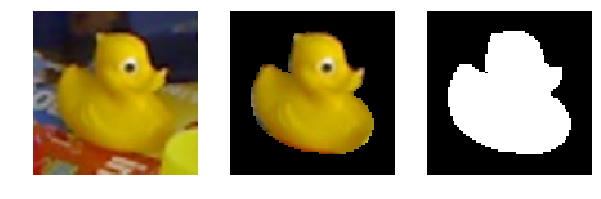

In [8]:
# Get specific test images
test_image, test_rec, test_mask = real_test_data.__getitem__(15) # Convert to 4d tensor (BxNxHxW)
test_image = test_image.unsqueeze(0)
test_rec = test_rec.unsqueeze(0)

test_data_image = ((test_image - test_image.min()) / (test_image.max() - test_image.min()))
test_data_rec = ((test_rec - test_rec.min()) / (test_rec.max() - test_rec.min()))

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(test_data_image[0].permute(1,2,0))
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(test_data_rec[0].permute(1,2,0))
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(test_mask[0],'gray')
plt.axis('off')

# Optimization

In [9]:
#shape invariant mean square error loss
def si_mse_loss(input, target):
    loss1 = ((input-target)**2).sum()/(input.view(-1).size()[0])
    loss2 = (((input-target).sum())**2)/((input.view(-1).size()[0])**2)
    loss = loss1 - loss2
    
    return loss
    
net_g = generator(params['ngf'])
net_g.weight_init(mean=0.0, std=0.02)
net_g = nn.DataParallel(net_g)
net_g.to(device)

net_d = discriminator(params['ndf'])
net_d.weight_init(mean=0.0, std=0.02)
net_d = nn.DataParallel(net_d)
net_d.to(device)

criterionGAN = GANLoss().to(device)

# setup optimizer
optimizer_g = optim.Adam(net_g.parameters(), lr=params['lr'])
optimizer_d = optim.Adam(net_d.parameters(), lr=params['lr'])

# Visualization

In [10]:
def visualization(model, test_path, rec_path):
    model.eval()
    model.to(device)
    transform = transforms.Compose([
            transforms.Resize(size=params['input_size']),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])     

    image = Image.open(test_path).convert("RGB")
    image = transform(image).unsqueeze_(0)
    out = model(image)
    out = to_np(out)
    out = out.squeeze()
    result = (((out - out.min()) * 255) / (out.max() - out.min())).transpose(1, 2, 0).astype(np.uint8)
    
    test_image = plt.imread(test_path)
    rec_image = plt.imread(rec_path)
    plt.figure(figsize=(8,8))
    display_list = [test_image, rec_image, result]
    title = ['Input Image', 'Ground Truth(Rec)', 'Predicted Image']
       
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

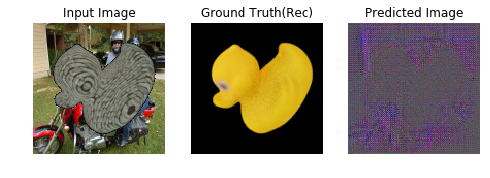

In [11]:
test_path = 'C:/Users/IVCL/Desktop/duck/blender/train/image/duck_00101.png'
rec_path = 'C:/Users/IVCL/Desktop/duck/blender/train/rec2/duck_00101.png'
mask_path = 'C:/Users/IVCL/Desktop/duck/blender/train/label/duck_00101.png'
visualization(net_g, test_path, rec_path)

# Training

In [12]:
checkpoint_path = './checkpoints_tc120_lm_blender_mix_l1_beta3_pix2pix(sim)'

In [ ]:
train_avg_gen_losses = []
val_avg_gen_losses = []
train_avg_disc_losses = []
val_avg_disc_losses = []
train_avg_rec_losses = []
val_avg_rec_losses = []

for epoch in range(params['epoch_count'], params['epochs'] + 1):
    # train
    net_g.to(device).train()
    net_d.to(device).train()
    
    train_gen_losses = []
    val_gen_losses = []
    train_disc_losses = []
    val_disc_losses = []
    train_rec_losses = []
    val_rec_losses = []
    
    for iteration, (batch_sim, batch_real) in enumerate(zip(sim_train_data_loader, real_train_data_loader)):
        # forward
        sim_a, sim_b, sim_mask = batch_sim[0].to(device), batch_sim[1].to(device), batch_sim[2].to(device)
        real_a, real_b, real_mask = batch_real[0].to(device), batch_real[1].to(device), batch_real[2].to(device)
        fake_sim_b = net_g(sim_a)
        sim_mask_reverse = torch.ones(1,params['input_size'],params['input_size']).to(device) - sim_mask
    
        ######################
        # (1) Update D network
        ######################

        optimizer_d.zero_grad()
        
        # train with fake
        pred_fake = net_d.forward(sim_a, fake_sim_b)
        loss_d_fake = criterionGAN(pred_fake, False)

        # train with real
        pred_real = net_d.forward(sim_a, sim_b)
        loss_d_real = criterionGAN(pred_real, True)
        
        # Combined D loss
        loss_d = (loss_d_fake + loss_d_real) * 0.5
        loss_d.backward(retain_graph=True)  
        optimizer_d.step()

        ######################
        # (2) Update G network
        ######################

        optimizer_g.zero_grad()

        # First, G(A) should fake the discriminator
        pred_fake = net_d.forward(sim_a, fake_sim_b)
        loss_g_gan = criterionGAN(pred_fake, True)

        # Second, G(A) = B
        #pmse loss
        multiply = torch.mul(fake_sim_b, sim_mask)
        multiply2 = torch.mul(fake_sim_b, sim_mask_reverse)        
        
        target1 = torch.mul(sim_b, sim_mask)
        target2 = torch.mul(sim_b, sim_mask_reverse)
        
        loss1 = torch.mean(torch.abs(multiply - target1))
        loss2 = torch.mean(torch.abs(multiply2 - target2))
        
        pmse_loss = loss1*params['alpha'] + loss2
        
        loss_g_l1 = pmse_loss * params['lamb1']
        
        #gen loss
        loss_g = loss_g_gan + loss_g_l1      
        loss_g.backward(retain_graph=True)
        optimizer_g.step()
        
        # loss values
        train_disc_losses.append(loss_d.item())
        train_gen_losses.append(loss_g_gan.item())
        train_rec_losses.append(loss_g_l1.item())

        if iteration % params['log_interval'] == 0:
            print("===> Epoch[{}/{}]({}/{}): Loss_D: {:.4f} Loss_G: {:.4f} Loss_Rec: {:.4f}".format(
                epoch, params['epochs'],iteration, len(real_train_data_loader), loss_d.item(), loss_g_gan.item(), loss_g_l1.item()))
    
    # avg loss values for plot
    train_avg_gen_loss = torch.mean(torch.FloatTensor(train_gen_losses))
    train_avg_disc_loss = torch.mean(torch.FloatTensor(train_disc_losses))
    train_avg_rec_loss = torch.mean(torch.FloatTensor(train_rec_losses))
    
    train_avg_gen_losses.append(train_avg_gen_loss.item())
    train_avg_disc_losses.append(train_avg_disc_loss.item())
    train_avg_rec_losses.append(train_avg_rec_loss.item())
    
    net_g.to(device).eval()
    net_d.to(device).eval()
    
    with torch.no_grad():
        for iteration, (batch_sim, batch_real) in enumerate(zip(sim_test_data_loader, real_test_data_loader)):
            # forward
            sim_a, sim_b, sim_mask = batch_sim[0].to(device), batch_sim[1].to(device), batch_sim[2].to(device)
            real_a, real_b, real_mask = batch_real[0].to(device), batch_real[1].to(device), batch_real[2].to(device)
            fake_sim_b = net_g(sim_a)
            fake_real_b = net_g(real_a)
            real_mask_reverse = torch.ones(1,params['input_size'],params['input_size']).to(device) - real_mask

            ######################
            # (1) Update D network
            ######################

            # train with fake
            pred_fake = net_d.forward(sim_a, fake_sim_b)
            loss_d_fake = criterionGAN(pred_fake, False)

            # train with real
            pred_real = net_d.forward(sim_a, sim_b)
            loss_d_real = criterionGAN(pred_real, True)

            # Combined D loss
            loss_d = (loss_d_fake + loss_d_real) * 0.5

            ######################
            # (2) Update G network
            ######################

            # First, G(A) should fake the discriminator
            pred_fake = net_d.forward(sim_a, fake_sim_b)
            loss_g_gan = criterionGAN(pred_fake, True)

            # Second, G(A) = B
            loss_g_l1 = F.mse_loss(fake_real_b, real_b)   
            
            val_disc_losses.append(loss_d.item())
            val_gen_losses.append(loss_g_gan.item())  
            val_rec_losses.append(loss_g_l1.item())
    
    # avg loss values for plot
    val_avg_gen_loss = torch.mean(torch.FloatTensor(val_gen_losses))
    val_avg_disc_loss = torch.mean(torch.FloatTensor(val_disc_losses))
    val_avg_rec_loss = torch.mean(torch.FloatTensor(val_rec_losses))
    
    val_avg_gen_losses.append(val_avg_gen_loss.item())
    val_avg_disc_losses.append(val_avg_disc_loss.item())
    val_avg_rec_losses.append(val_avg_rec_loss.item())
    
    print("Val_Loss_D: {:.4f} Val_Loss_G: {:.4f} Val_Loss_Rec: {:.4f}".format(
        val_avg_disc_loss.item(), val_avg_gen_loss.item(), val_avg_rec_loss.item()))
    
    # Show result for test image
    test_A = test_image.cuda()
    test_B = test_rec.cuda()
    fake_B = net_g(test_A)
    
    plot_train_result([test_A, test_B, fake_B], epoch, save=False)
    
    # Save weight
    if epoch % 1 == 0:
        torch.save(net_g.state_dict(), checkpoint_path+'/net_g-%s.pt'%epoch)
        torch.save(net_d.state_dict(), checkpoint_path+'/net_d-%s.pt'%epoch)
    
    # Plot loss
    if epoch % 10 == 0:
        plt.figure(figsize=(10,10))
        plt.subplot(3,1,1)
        plt.plot(train_avg_gen_losses, label='train')
        plt.plot(val_avg_gen_losses, label='val')
        plt.xlabel('Epoch')
        plt.ylabel('Generator_Loss')
        plt.legend()

        plt.subplot(3,1,2)
        plt.plot(train_avg_disc_losses, label='train')
        plt.plot(val_avg_disc_losses, label='val')
        plt.xlabel('Epoch')
        plt.ylabel('Discriminator_Loss')
        plt.legend()
        
        plt.subplot(3,1,3)
        plt.plot(train_avg_rec_losses, label='train')
        plt.plot(val_avg_rec_losses, label='val')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction_Loss')
        plt.legend()

In [14]:
print('Disc Loss :',np.array(val_avg_disc_losses).argmin()+1,
      '\tGan Loss :',np.array(val_avg_gen_losses).argmin()+1,
      '\tRec Loss :',np.array(val_avg_rec_losses).argmin()+1)

Disc Loss : 11 	Gan Loss : 75 	Rec Loss : 27


# Loss Curve

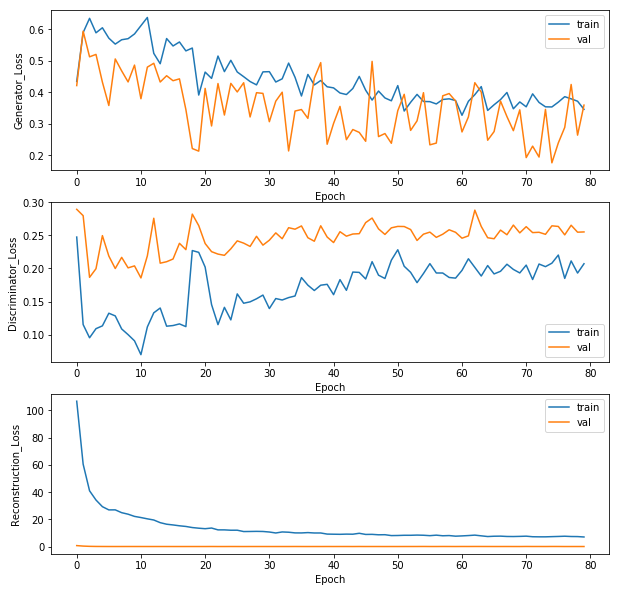

In [15]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(train_avg_gen_losses, label='train')
plt.plot(val_avg_gen_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Generator_Loss')
plt.legend()

plt.subplot(3,1,2)
plt.plot(train_avg_disc_losses, label='train')
plt.plot(val_avg_disc_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Discriminator_Loss')
plt.legend()

plt.subplot(3,1,3)
plt.plot(train_avg_rec_losses, label='train')
plt.plot(val_avg_rec_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction_Loss')
plt.legend()

# Restore Checkpoint

In [16]:
weight_dict = torch.load(checkpoint_path+'/net_g-27.pt')

In [17]:
net_g.load_state_dict(weight_dict)

<All keys matched successfully>

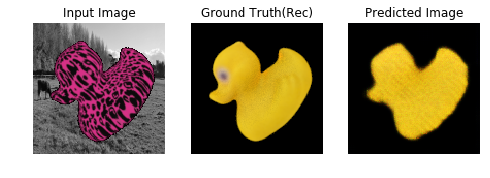

In [18]:
num = '00288'
test_path = 'C:/Users/IVCL/Desktop/duck/blender_mix/train/image/duck_{}.png'.format(num)
rec_path = 'C:/Users/IVCL/Desktop/duck/blender_mix/train/rec2/duck_{}.png'.format(num)
mask_path = 'C:/Users/IVCL/Desktop/duck/blender_mix/train/label/duck_{}.png'.format(num)
visualization(net_g, test_path, rec_path)

In [24]:
def save(model, test_path, num):
    model.eval()
    model.to(device)
    transform = transforms.Compose([
            transforms.Resize(size=params['input_size']),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])     

    image = Image.open(test_path).convert("RGB")
    image = transform(image).unsqueeze_(0)
    out = model(image)
    out = to_np(out)
    out = out.squeeze()
    result = (((out - out.min()) * 255) / (out.max() - out.min())).transpose(1, 2, 0).astype(np.uint8)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    cv2.imwrite('C:/Users/IVCL/Desktop/duck_pred/%s.png'%num, result)

In [25]:
import cv2

test_paths = glob('C:/Users/IVCL/Desktop/duck/real/image/*.png')

i = 0
for path in test_paths:
    rec_path = path[:-20]+'rec2/'+path[-14:]
    mask_path = path[:-20]+'label/'+path[-14:]
    i = i+1
    save(net_g, path, i)

In [ ]:
test_paths = glob('C:/Users/IVCL/Desktop/duck/real/test/image/*.png')

i = 0
for path in test_paths:
    rec_path = path[:-20]+'rec2/'+path[-14:]
    mask_path = path[:-20]+'label/'+path[-14:]
    i = i+1
    print('num_image :',i)
    visualization(net_g, path, rec_path)

In [20]:
test_mse = 0
num_test = 0
for batch_idx, (img, rec, mask) in enumerate(real_test_data_loader):
    img, rec, mask = img.to(device), rec.to(device), mask.to(device)
    rec_output = net_g(img)
    test_mse += F.mse_loss(rec_output, rec)
    num_test += 1
    
print('test_mse :',test_mse / num_test)

test_mse : tensor(0.0359, device='cuda:0', grad_fn=<DivBackward0>)
